In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import math

from ipywidgets import interact

from ipywidgets import widgets
from tqdm.auto import tqdm

from dataclasses import dataclass
from typing import Union, Callable, Optional
from copy import deepcopy
from scipy.optimize import root_scalar, brentq
from dataclasses import dataclass
from scipy.special import iv
from scipy.stats import bernoulli
from scipy.interpolate import RectBivariateSpline

import warnings
from  scipy.stats import norm
warnings.filterwarnings("ignore")

# Heston model

Heston model can be written in following way:

$$dS_t/S_t  = rdt + \sqrt{V_t} dW_1$$

$$dV_t = \kappa (\bar V-V_t)dt + \gamma \sqrt V_t dW_2$$

$$dW_1 dW_2 = \rho dt$$

## Euler scheme

It can be simulated in discrete time using Euler scheme by selecting a time step $∆t$ starting at $S_0, V_0$:

$$\log s_{i} = \log s_{i-1} + (r - v_{i-1}^+/2)\Delta t+ \sqrt{v_{i-1}^+ \Delta t}(  ρε^1_{i} + \sqrt{1- ρ^2} ε^2_{i})],$$

$$v_{i} =  v_{i-1} + \kappa (\bar V-v_{i-1}^+)\Delta t + \gamma \sqrt{ v_{i-1}^+ \Delta t}ε^1_{i}$$

(section 2.3 eq. 6-7 Andersen (2006) )

In [3]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

@dataclass
class HestonParameters:
    kappa:  Union[float, np.ndarray]
    gamma:  Union[float, np.ndarray]
    rho:  Union[float, np.ndarray]
    vbar:  Union[float, np.ndarray]
    v0:  Union[float, np.ndarray]
        
@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    interest_rate: Union[float, np.ndarray]

In [4]:


def get_len_conf_interval(data: np.ndarray, 
                          confidence_level: float = 0.05):
    """Get the confidence interval for a given confidence level.
    Args:
        data: The data to compute the confidence interval for.
        confidence_level: The confidence level to use.
    
    Returns:
        The confidence interval.
    """

    mean = np.mean(data)
    l = sps.norm.ppf(confidence_level / 2) * np.sqrt(np.var(data) / len(data))
    return [mean - l, mean + l]

def get_number_of_simulations(data: np.ndarray, 
                              confidence_level: float = 0.05, 
                              absol_error: float = 1e-2):
    """Get the length of the confidence interval for a given confidence level.
    Args:
        data: The undersampled data to compute the sample variance.
        confidence_level: The confidence level to use.
    
    Returns:
        The number of simulations.
    """
    return int((2*sps.norm.ppf(confidence_level / 2))**2 * np.var(data) / absol_error)

def get_number_of_batches(data: np.ndarray, 
                          confidence_level: float = 0.05, 
                          absol_error: float = 5e-3, 
                          batch_size: int = 10000):
    """Get the number of batches needed to achieve a given relative error using the MC simulations.
    Args:
        absol_error: The relative error to achieve. Defaults to 0.005 (cor˝responds to 0.5 cents).
        batch_size: The batch size to use. Defaults to 10000.
    
    Returns:
        The number of batches needed to achieve the given relative error.
    """
    return int(get_number_of_simulations(data, confidence_level, absol_error) / batch_size)+1

In [6]:
def simulate_heston_euler(state: MarketState,
                                heston_params: HestonParameters,
                                time: float = 1.,
                                dt: float = 1e-2,
                                time_batch_size: int = 10_000,
                                n_simulations: int = 10_000) -> dict:
    
    if time<=0:
        raise Error("time must be bigger then 0")
    
    # initialize market and model parameters
    r, s0 = state.interest_rate, state.stock_price
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    
    vt = np.zeros(n_simulations)
    vt[:] = v0
    log_st = np.zeros(n_simulations)
    log_st[:] = np.log(s0)
    
    N_T = int(time / dt)
    num_of_time_batch = int(N_T/time_batch_size)
    
    for k in range(num_of_time_batch):
        Z1 = np.random.normal(size=(n_simulations, time_batch_size))
        Z2 = np.random.normal(size=(n_simulations, time_batch_size))
        V = np.zeros([n_simulations, time_batch_size])
        V[:, 0] = vt

        logS = np.zeros([batch_size, time_batch_size])
        logS[:, 0] = log_st

        for i in range(0, time_batch_size-1):
            vmax=np.maximum(V[:, i],0)
            S1 = (r - 0.5 * vmax) * (dt)
            S2 = np.sqrt(vmax*(dt)) * Z1[:, i]
            logS[:, i+1] = logS[:, i] + S1 + S2
            V1 = kappa*(vbar - vmax)*(dt)
            V2 = gamma*np.sqrt(vmax*(dt))*(rho*Z1[:, i]+np.sqrt(1-rho**2)*Z2[:, i])
            V[:, i+1] = V[:, i] + V1 + V2
        vt = V[:, time_batch_size-1]
        log_st = logS[:, time_batch_size-1]

    if N_T > num_of_time_batch*time_batch_size:
        add_batch_time = N_T - num_of_time_batch*time_batch_size

        Z1 = np.random.normal(size=(n_simulations, add_batch_time))
        Z2 = np.random.normal(size=(n_simulations, add_batch_time))
        V = np.zeros([n_simulations, add_batch_time])
        V[:, 0] = vt

        logS = np.zeros([n_simulations, add_batch_time])
        logS[:, 0] = log_st

        for i in range(0, add_batch_time-1):
            vmax=np.maximum(V[:, i],0)
            S1 = (r - 0.5 * vmax) * (dt)
            S2 = np.sqrt(vmax*(dt)) * Z1[:, i]
            logS[:, i+1] = logS[:, i] + S1 + S2
            V1 = kappa*(vbar - vmax)*(dt)
            V2 = gamma*np.sqrt(vmax*(dt))*(rho*Z1[:, i]+np.sqrt(1-rho**2)*Z2[:, i])
            V[:, i+1] = V[:, i] + V1 + V2
        vt = V[:, add_batch_time-1]
        log_st = logS[:, add_batch_time-1]
        
    mean_St = np.mean(np.exp(log_st)) #/float(n_simulations)
    mean_vt = np.mean(vt) #/float(n_simulations)         
    
    #put the calculated values into the dictionary
    
    return {"asset": mean_St, "volatility": mean_vt}

## Broadie - Kaya scheme

In [7]:
def cir_chi_sq_sample(heston_params: HestonParameters,
                      dt: float,
                      v_i: np.array,
                      n_simulations: int):
    """Samples chi_sqqred statistics for v_{i+1} conditional on 
       v_i and parameters of Hestom model. 
        
    Args:
        heston_params (HestonParameters): parameters of Heston model
        dt (float): time step 
        v_i: current volatility value
        n_simulations (int): number of simulations.
        
    Returns:
        np.array: sampled chi_squared statistics 
    """
    kappa, vbar, gamma = heston_params.kappa, heston_params.vbar, heston_params.gamma
    
    barkappa=v_i*(4*kappa*np.exp(-kappa*dt))/(gamma**2 * (1 - np.exp(-kappa*dt)))
    d=(4*kappa*vbar)/(gamma**2)
    c=((gamma**2)/(4*kappa))*(1-np.exp(-kappa*dt))
    
    return  c*np.random.noncentral_chisquare(size = n_simulations, df   = d, nonc = barkappa)


def Phi(a: Union[float, np.ndarray], 
         V: Union[float, np.ndarray],
         time: Union[float, np.ndarray],
         heston_params: HestonParameters) -> np.ndarray:
    
    
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                        heston_params.vbar, heston_params.gamma
    dt = time[1::]-time[:-1:]
    
    A=np.array(a)
    gamma_a = np.sqrt(kappa**2 - 2*gamma**2*1j*A).reshape(1,1,len(A)).T
    
    E1 = np.exp(-kappa*dt)
    E2 = np.exp(-gamma_a * dt)
        
    P1 = ((1.0-E1)*gamma_a/(kappa*(1.0-E2)))*np.exp(-0.5*(gamma_a - kappa)*dt)
    
    P2_2 = kappa * (1.0 + E1)/(1.0 - E1) - gamma_a*(1.0+E2)/(1-E2)
    P2 = np.exp( (V[:,1::]+V[:,:-1:])/(gamma_a**2) * P2_2 )
    
    P3_1 = np.sqrt(V[:,1::]*V[:,:-1:])*4*gamma_a * np.exp(-0.5*gamma_a*dt) /(gamma**2 * (1.0 - E2))
    P3_2 = np.sqrt(V[:,1::]*V[:,:-1:])*4*kappa*np.exp(-0.5*kappa*dt)/(gamma**2 * (1 - E1))
    d=(4*kappa*vbar)/(gamma**2)
    P3 = iv(0.5*d - 1, P3_1)/iv(0.5*d - 1, P3_2)
    
    return P1*P2*P3

def Pr(V: np.ndarray, time: np.ndarray,
       X: Union[np.ndarray, float],
       heston_params: HestonParameters,
       h: float=1e-2, eps: float=1e-2) -> np.ndarray:
    
    x=np.array(X)
    P=h*x/np.pi
    S = 0.0
    j = 1
    while(True):
        Sin=np.sin(h*j*x)/j
        Phi_hj=Phi(h*j, V, time, heston_params)
        S+=Sin.reshape(1,1,len(x)).T * Phi_hj[0]
        if np.all(Phi_hj[0]<np.pi*eps*j/2.0):
            break
        j=j+1
    
    S=S*2.0/np.pi
    return P+S

def IV(V: np.ndarray, time: np.ndarray,
       heston_params: HestonParameters,
       h: float=1e-2, eps: float=1e-2) -> np.ndarray:
    
    U=np.random.uniform(size=(V.shape[0], V.shape[1] - 1))
    
    def f(x,i,j):
        P=Pr(V, time, x, heston_params, h, eps)
        return (P-U)[0][i,j]
    
    IVar = np.zeros((V.shape[0], V.shape[1] - 1))
    
    for i in range(IVar.shape[0]):
        for j in range(IVar.shape[1]):     
            IVar[i,j]=root_scalar(f, args=(i,j), x0=0.5, method='newton')
    return IVar

# Andersen scheme

In [14]:
def simulate_heston_andersen(state: MarketState,
                                    heston_params: HestonParameters,
                                    time: float = 1.,
                                    dt: float = 1e-2,
                                    n_simulations: int = 10_000,
                                    time_batch_size: int = 10_000,
                                    Psi_c: float=1.5,
                                    gamma_1: float=0.5) -> dict:
    
    
    if Psi_c>2 or Psi_c<1:
        raise Error('1<=Psi_c<=2 ')
    if gamma_1 >1 or gamma_1<0:
        raise Error('0<=gamma_1<=1')
        
    gamma_2 = 1.0 - gamma_1
    
    r, s0 = state.interest_rate, state.stock_price
    v0, rho, kappa, vbar, gamma = heston_params.v0, heston_params.rho, heston_params.kappa, \
                                  heston_params.vbar, heston_params.gamma
    
    
    E = np.exp(-kappa*dt)
    
    K_0 = -(rho*kappa*vbar/gamma)*dt
    K_1 = gamma_1*dt*(rho*kappa/gamma - 0.5) - rho/gamma
    K_2 = gamma_2*dt*(rho*kappa/gamma - 0.5) + rho/gamma
    K_3 = gamma_1*dt*(1.0 - rho**2)
    K_4 = gamma_2*dt*(1.0 - rho**2)
    
    N_T = int(time / dt)
    num_of_time_batch = int(N_T/time_batch_size)
    
    
    vt = np.zeros(n_simulations)
    vt[:] = v0
    log_st = np.zeros(n_simulations)
    log_st[:] = np.log(s0)
    
    mean_St = 0.
    mean_vt = 0.
    
        
    vt[:] = v0
    log_st[:] = np.log(s0)
        
    for k in range(num_of_time_batch):

        V = np.zeros([n_simulations, time_batch_size])
        V[:, 0] = vt

        logS = np.zeros([n_simulations, time_batch_size])
        logS[:, 0] = log_st

        Z = np.random.normal(size=(n_simulations, time_batch_size))


        for i in range(time_batch_size - 1):
            m=vbar+(V[:, i] - vbar)*E
            s_2 = (V[:, i]*(gamma**2)*E/kappa)*(1.0 - E) + (vbar*gamma**2)/(2.0*kappa)*((1-E)**2)

            Psi = s_2/(m**2)

            cond = np.where(Psi<=Psi_c)
            c = 2/Psi[cond]
            b = c - 1 + np.sqrt(c*(c - 1))
            a = m[cond]/(1+b)
            b=np.sqrt(b)
            Z_V = np.random.normal(size=cond[0].shape[0])
            V[cond, i+1] = a*((b+Z_V)**2)

            cond = np.where(Psi>Psi_c)
            p = (Psi[cond] - 1)/(Psi[cond] + 1)
            beta = (1.0 - p)/m[cond]

            ksi = np.random.binomial(1, 1.0-p, size=cond[0].shape[0])
            eta = np.random.exponential(scale = 1/beta, size=cond[0].shape[0])
            V[cond,i+1]=ksi*eta


            logS[:,i+1] = logS[:,i] + r*dt+K_0 + K_1*V[:,i] + K_2*V[:,i+1] \
                            + np.sqrt(K_3*V[:,i]+K_4*V[:,i+1]) * Z[:,i]

        vt = V[:, time_batch_size-1]
        log_st = logS[:, time_batch_size-1]

    if N_T > num_of_time_batch*time_batch_size:

        add_batch_time = N_T - num_of_time_batch*time_batch_size

        V = np.zeros([n_simulations, add_batch_time])
        V[:, 0] = vt
        logS = np.zeros([n_simulations, add_batch_time])
        logS[:, 0] = log_st
        
        Z = np.random.normal(size=(n_simulations, add_batch_time))

        for i in range(add_batch_time - 1):
            m=vbar+(V[:, i] - vbar)*E
            s_2 = (V[:, i]*(gamma**2)*E/kappa)*(1.0 - E) + (vbar*gamma**2)/(2.0*kappa)*((1-E)**2)

            Psi = s_2/(m**2)

            cond = np.where(Psi<=Psi_c)
            c = 2/Psi[cond]
            b = c - 1 + np.sqrt(c*(c - 1))
            a = m[cond]/(1+b)
            b=np.sqrt(b)
            Z_V = np.random.normal(size=cond[0].shape[0])
            V[cond, i+1] = a*((b+Z_V)**2)

            cond = np.where(Psi>Psi_c)
            p = (Psi[cond] - 1)/(Psi[cond] + 1)
            beta = (1.0 - p)/m[cond]

            ksi = np.random.binomial(1, 1.0-p, size=cond[0].shape[0])
            eta = np.random.exponential(scale = 1/beta, size=cond[0].shape[0])
            V[cond,i+1]=ksi*eta


            logS[:,i+1] = logS[:,i] + r*dt+K_0 + K_1*V[:,i] + K_2*V[:,i+1] \
                            + np.sqrt(K_3*V[:,i]+K_4*V[:,i+1]) * Z[:,i]

        vt = V[:, add_batch_time-1]
        log_st = logS[:, add_batch_time-1]

    mean_St = np.mean(np.exp(log_st))
    mean_vt = np.mean(vt)
            
            
        
    #put the calculated values into the dictionary
    simulated_paths = {"asset": mean_St, "volatility": mean_vt}
    return simulated_paths

In [20]:
time = 2.
heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, 
                                     rho = -0.3937, vbar = 0.0641, 
                                     v0 = 0.3)

state = MarketState(stock_price = 100., interest_rate = 0.)

n_simulations = 120000

eul = simulate_heston_euler(state = state, heston_params = heston_parameters,
                            time = time)

ander = simulate_heston_andersen(state= state, heston_params = heston_parameters, time = 2.)

{'asset': 100.32940076023728, 'volatility': 0.08285207165383011}

In [ ]:
def plot_random_paths(times: np.array, 
                      simulated_paths: dict,
                      type_of_scheme: str = "Euler",
                      plot_paths: int = 15):
    """Plots some simulated paths.
    
    Args:
        simulated_paths (dict): paths of an asset and volatility values.
    """
    #take random paths indexes
    n_simulatinos = simulated_paths["asset"].shape[0]
    random_indexes = np.random.choice(n_simulatinos, plot_paths)
    
    #take paths corresponding to sampled indexes
    asset_paths = simulated_paths["asset"][random_indexes]
    volatility_paths = simulated_paths["volatility"][random_indexes]
    
    #plot asset prices and volatilities 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,9))
    fig.suptitle("{} scheme simulated Heston model".format(type_of_scheme))    
    fig.subplots_adjust(hspace=0.4)
    
    for i in range(plot_paths):
        ax1.plot(times, asset_paths[i])
        ax2.plot(times, volatility_paths[i])
        
    ax1.set_xlabel('time')
    ax1.set_ylabel('Asset')
    ax1.grid(True)
    
    ax2.set_xlabel('time')
    ax2.set_ylabel('Volatility')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()  

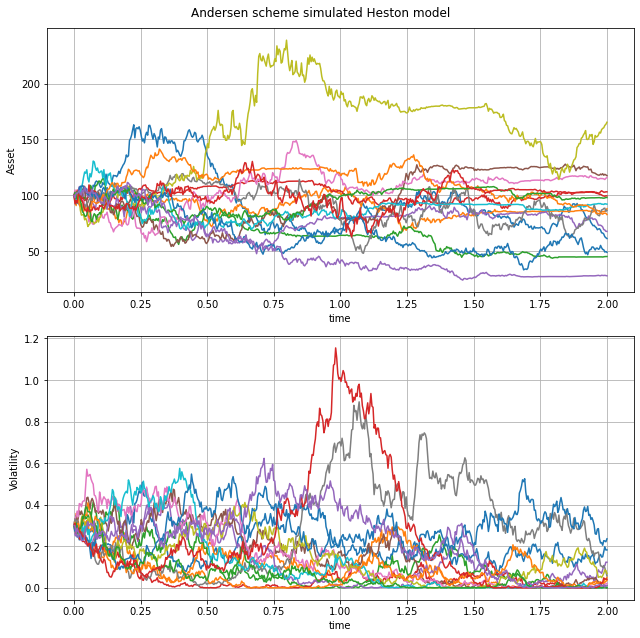

In [123]:
plot_random_paths(time, paths, type_of_scheme = "Andersen")

In [124]:
def present_value(time: Union[float, np.ndarray],
                  value: Union[float, np.ndarray],
                  interest_rate: float) -> Union[float, np.ndarray]:
    """Calculates present value of payoff(s) occuread at given time(s)
    
    Args:
        time (float or np.ndarray): time(s) in years at which payoff occured
        value (float or np.ndarray): value(s) of the payoff(s)
        interest_rate (float): continuous annualized constant discount rate
    
    Returns:
        float or np.ndarray: continuously discounted value
    """ 
    return np.exp(-interest_rate * time) * value

def mc_price(option: StockOption, 
             state: MarketState, 
             heston_params: HestonParameters,
             n_simulations: int = 10_000,
             type_of_scheme: str = "Euler",
             **kwargs) -> Union[float, np.ndarray]:
    """Calculates MC price of an option.
    
     Args:
        option(StockOption): call or put option.
        state (MarketState): initial market state to start from.
        heston_params (HestonParameters): parameters of Heston model. 
        n_simulations (int): number of simulations.
        type_of_scheme(str): type of scheme (Euler or Broadie-Kaya)

    Returns:
        float or np.ndarray: continuously discounted value
    
    """
    time = option.expiration_time
    
    args={"time": time, "n_simulations": n_simulations, "state": state, "heston_params": heston_params}
    args={**args, **kwargs}
    schemes = { "Euler": simulate_paths_heston_euler, "Broadie-Kaya": None, "Andersen": simulate_paths_heston_andersen}
    
    price = schemes[type_of_scheme](**args)
    price_shape = price["asset"].shape
    price = price["asset"].reshape(*price_shape, 1)
            
            
    shape = option.strike_price.shape
    
    if option.is_call:
        payoff = np.maximum(0, price - np.reshape(option.strike_price, (1, *shape)))
    else:
        payoff = np.maximum(0, np.reshape(option.strike_price, (1, *shape)) - price)
        
    price =  present_value(time=option.expiration_time,
                           value=payoff.mean(0),
                           interest_rate=state.interest_rate)

    return price

In [125]:
np.random.seed(42)

strikes = np.linspace(50, 150, 50)
times = np.linspace(0.1, 2, 100)
n_simulations = 10000

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))

puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))

heston_parameters = HestonParameters(kappa = 1.3125, gamma = 0.7125, rho = -0.3937, vbar = 0.0641, v0 = 0.1181)
state = MarketState(stock_price = 100, interest_rate = 0.01)

x, y = np.meshgrid(strikes, times)
call_price_andersen = mc_price(calls, state, heston_parameters, n_simulations, "Andersen")
put_price_andersen = mc_price(puts, state, heston_parameters, n_simulations, "Andersen")

call_price_euler = mc_price(calls, state, heston_parameters, n_simulations, "Euler")
put_price_euler = mc_price(puts, state, heston_parameters, n_simulations, "Euler")

Text(0.5, 0, 'Option price, $')

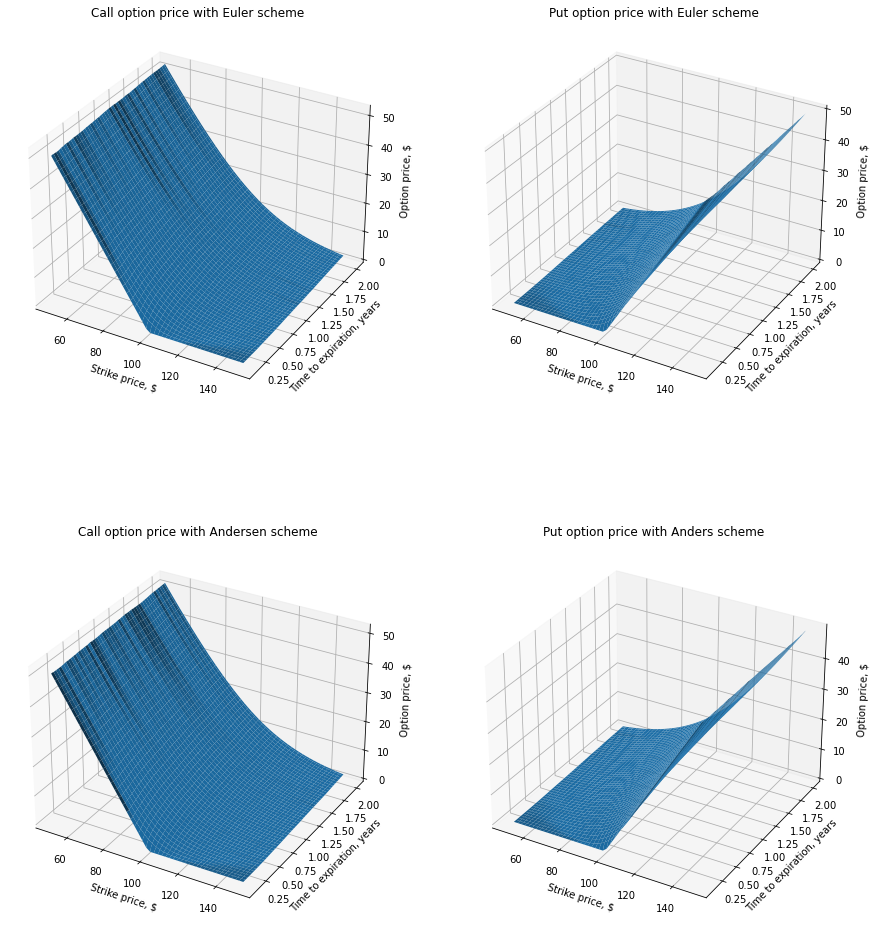

In [126]:
fig = plt.figure(figsize=(15, 35))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price_andersen)
ax1.set_title('Call option price with Andersen scheme')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price_andersen)
ax2.set_title('Put option price with Anders scheme')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(x, y, call_price_euler)
ax1.set_title('Call option price with Euler scheme')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(x, y, put_price_euler)
ax2.set_title('Put option price with Euler scheme')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')




In [127]:
def prices_func(times, strikes, price):
    def interp_price_func(t, s):
        interp=RectBivariateSpline(times,strikes,call_price_andersen)
        return interp(t,s, grid=False)
    return interp_price_func

In [128]:
def d_1(q,T,S,K,r):
    denom=1/(q*np.sqrt(T))
    log=np.log(S/K)
    s2=T*(r+q*q/2)
    return denom*(log+s2)

def d_2(q,T,S,K,r):
    denom=1/(q*np.sqrt(T))
    log=np.log(S/K)
    s2=T*(r-q*q/2)
    
    return denom*(log+s2)

def calc_iv(option: CallStockOption, state: MarketState, option_price: float):
    
    T=option.expiration_time
    K=option.strike_price
    S=state.stock_price
    r=state.interest_rate    
    N=sps.norm()
    
    
    def f(q):
        d1=d_1(q,T,S,K,r)
        d2=d_2(q,T,S,K,r)
        return S*N.cdf(d1)-K*(np.exp(-r*T))*N.cdf(d2)-option_price
    
    def fprime(q):
        d1=d_1(q,T,S,K,r)
        return S*sps.norm().pdf(d1)*np.sqrt(T)
    
    sol = root_scalar(f, x0=0.5, fprime=fprime, method='newton')
    return sol.root



In [129]:


IV = np.empty_like(call_price_andersen)

for i in range(len(calls.expiration_time)):
    for j in range(len(calls.strike_price)):
        IV[i, j] = calc_iv(option=CallStockOption(calls.strike_price[0][j], calls.expiration_time[i][0]), 
                           state=state, 
                           option_price=call_price_andersen[i, j])

In [140]:
IV[99][4::]

array([ 1.71249002,  1.93539882,  2.18127043,  2.45051698,  2.74449066,
        3.0663368 ,  3.41743582,  3.80041135,  4.21655675,  4.6668477 ,
        5.15018988,  5.6701812 ,  6.2296744 ,  6.82473888,  7.46079779,
        8.14253755,  8.87127102,  9.64616157, 10.47350669, 11.35051202,
       12.28024182, 13.25673949, 14.28322819, 15.36103501, 16.49257295,
       17.67476429, 18.90203468, 20.17832836, 21.50462547, 22.87487384,
       24.2889584 , 25.74468821, 27.24114924, 28.77682424, 30.34896331,
       31.95344059, 33.58921   , 35.25248458, 36.93917412, 38.65193898,
       40.38829837, 42.14434738, 43.9179666 , 45.71018647, 47.52015703,
       49.34422294])

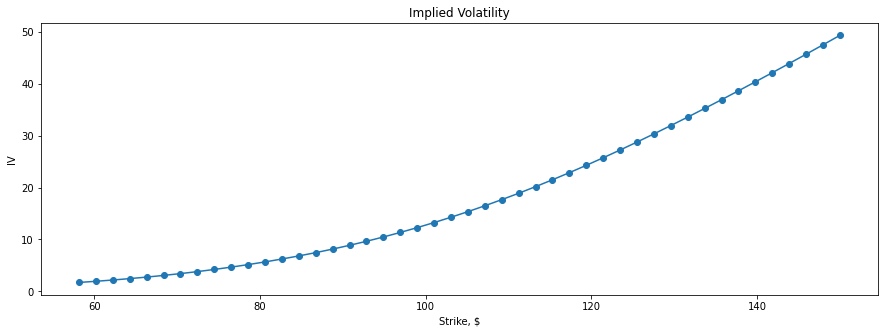

In [138]:
_, ax = plt.subplots(figsize=(15, 5))

ax.plot(strikes[4::], IV[99][4::], "o-")
# ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV")
ax.set_title("Implied Volatility")
plt.show()